# HackMed 21: Path Finding for Hits
Start: 25.04.2021 | author: Georgeos Hardo; helper: Camillo Moschner
Source Data: 

## Import Statements

In [94]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdChemReactions as rdReact
from rdkit.Chem import Draw
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Function Definitions

In [35]:
def find_similarity(mol1_ChEBI,mol2_ChEBI,ChEBI_id_df,plot=False):
    mol1_ChEBI = int(mol1_ChEBI)
    mol2_ChEBI = int(mol2_ChEBI)

    molecule1 = ChEBI_id_df[ChEBI_id_df["ChEBI ID"] == mol1_ChEBI]["rdkit_mol"].iloc[0]
    molecule2 = ChEBI_id_df[ChEBI_id_df["ChEBI ID"] == mol2_ChEBI]["rdkit_mol"].iloc[0]
    fps1 = Chem.RDKFingerprint(molecule1)
    fps2 = Chem.RDKFingerprint(molecule2)
    if plot == True:
        fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(molecule1,molecule2, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.TanimotoSimilarity)
    return DataStructs.FingerprintSimilarity(fps1,fps2,metric=DataStructs.TanimotoSimilarity)

def getshortest_paths(graph, source, target):
    """
    Find shortest chemical distance between two given molecules.
    """
    source = str(source)
    target = str(target)
    return list(nx.algorithms.shortest_paths.generic.all_shortest_paths(graph,source=source,target=target))

def find_best_shortest_path(path_list, ChEBI_id_df):
    minimum_path_similarity = []
    missing_from_ChEBI_db = []
    for path in path_list:
        similarities = []
        for x in range(len(path)-1):
            try:
                similarities.append(find_similarity(path[x],path[x+1],ChEBI_id_df))
            except:
                missing_from_ChEBI_db.append([path[x],path[x+1]])
        minimum_path_similarity.append(np.min(similarities))
    return np.array(paths)[np.where(minimum_path_similarity == np.max(minimum_path_similarity))][0], np.max(minimum_path_similarity)

def get_mol_file(ChEBI_int):
    return ChEBI_df[ChEBI_df['ChEBI ID']== ChEBI_int]["rdkit_mol"].iloc[0]

## Load Data

In [3]:
suppl = Chem.SDMolSupplier('/Users/camillomoschner/Documents/GitHub/react2drug/ChEBI_complete_3star.sdf')
molecules = []
ChEBI_list = []
for mol in suppl:
    try:
        ChEBI_list.append(mol.GetPropsAsDict())
        molecules.append(mol)
    except:
        pass
ChEBI_df = pd.DataFrame(ChEBI_list)
ChEBI_df["ChEBI ID"] = ChEBI_df["ChEBI ID"].str.split(":").str[-1].astype(int)
ChEBI_df["rdkit_mol"] = molecules

RDKit WARNING: [12:33:19] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:33:20] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [12:33:20] ERROR: Could not sanitize molecule ending on line 680779
RDKit ERROR: [12:33:20] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [12:33:20] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [12:33:20] ERROR: Could not sanitize molecule ending on line 681046
RDKit WARNING: [12:33:24] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [12:33:24] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [12:33:25] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit ERROR: [12:33:20] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [12:33:25] Can't kekulize mol.  Unkekulized atoms: 1 3 5 7 8
RDKit ERROR: 
RDKit ERROR: [12:33:25] ERROR: Could not san

In [4]:
drug_hits = pd.read_pickle("pickled_data/drug_hit_ChEBIs.p")

In [5]:
unique_drugs = drug_hits["drug_ChEBI"].unique()

In [65]:
G = nx.readwrite.graphml.read_graphml("g.graphml")

Define source and final target molecule:

In [85]:
start_molecule = "58885"
target_molecule = "17026"

## Graph Analysis
Identify a list of shortest paths:

In [86]:
paths = getshortest_paths(G,start_molecule,target_molecule)
paths

[['58885', '68654', '138140', '33722', '17026'],
 ['58885', '161167', '138140', '33722', '17026'],
 ['58885', '101100', '138140', '33722', '17026'],
 ['58885', '102103', '138140', '33722', '17026'],
 ['58885', '103104', '138140', '33722', '17026'],
 ['58885', '102105', '138140', '33722', '17026'],
 ['58885', '103106', '138140', '33722', '17026'],
 ['58885', '12833', '138140', '33722', '17026'],
 ['58885', '127128', '138140', '33722', '17026'],
 ['58885', '145044', '16581', '63837', '17026']]

From these shortest paths identify the best one, i.e. the one where the overall chemical similarity between each molecule and the next one in the pathway is highest (this decreases the chances of accidentally picking molecules that can be involved in the pathway but aren't actually):

In [157]:
best_path = find_best_shortest_path(paths, ChEBI_df)[0]
best_path

array(['58885', '145044', '16581', '63837', '17026'], dtype='<U6')

In [80]:
rhea_IDs

[61826, 61826, 43925, 43930]

Load mole files from ChEBI database:

In [83]:
rhea_IDs = []
for x in range(len(best_path)-1):
    ID_1 = str(best_path[x])
    ID_2 = str(best_path[x+1])
    rhea_id = G.get_edge_data(ID_1,ID_2)["rhea_ID"]
    rhea_IDs.append(rhea_id)
    reaction = rdReact.ReactionFromRxnFile('/Users/camillomoschner/Desktop/21_HackMed/rxn/{}.rxn'.format(str(rhea_id)))
    reaction_im = (Chem.Draw.ReactionToImage(reaction))
    reaction_im.save("{}.png".format(x))

In [28]:
np.array(paths)[np.where(test == np.max(test))][0]

array(['58885', '145044', '16581', '63837', '17026'], dtype='<U6')

In [156]:
rhea_IDs

[61826, 61826, 43925, 43930]

In [38]:
ChEBI_df

,ChEBI ID,ChEBI Name,Star,Definition,Secondary ChEBI ID,InChI,InChIKey,SMILES,Formulae,Charge,...,GlyTouCan Database Links,LIPID MAPS class Database Links,RESID Database Links,WebElements Database Links,FAO/WHO standards Database Links,PPR Links,CiteXplore citation Links,SMID Database Links,ChemIDplus Database Links,rdkit_mol
0,90,(-)-epicatechin,3,"A catechin with (2R,3R)-configuration.",CHEBI:18484,InChI=1S/C15H14O6/c16-8-4-11(18)9-6-13(20)15(2...,PFTAWBLQPZVEMU-UKRRQHHQSA-N,[H][C@@]1(Oc2cc(O)cc(O)c2C[C@H]1O)c1ccc(O)c(O)c1,C15H14O6,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x10c7077c0>
1,165,"(1S,4R)-fenchone",3,"A fenchone that has 1S,4R stereochemistry. A c...",CHEBI:63901,"InChI=1S/C10H16O/c1-9(2)7-4-5-10(3,6-7)8(9)11/...",LHXDLQBQYFFVNW-XCBNKYQSSA-N,CC1(C)[C@@H]2CC[C@@](C)(C2)C1=O,C10H16O,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x10c5e8a00>
2,598,1-alkyl-2-acylglycerol,3,A glycerol ether having an alkyl substituent a...,CHEBI:19009,NaN,NaN,OCC(CO[*])OC([*])=O,C4H6O4R2,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x16bf7f3a0>
3,776,16alpha-hydroxyestrone,3,The 16alpha-hydroxy derivative of estrone; a m...,CHEBI:60497,InChI=1S/C18H22O3/c1-18-7-6-13-12-5-3-11(19)8-...,WPOCIZJTELRQMF-QFXBJFAPSA-N,[H][C@]12CC[C@]3(C)C(=O)[C@H](O)C[C@@]3([H])[C...,C18H22O3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x16bf7f400>
4,943,"2,6-dichlorobenzonitrile",3,A nitrile that is benzonitrile which is substi...,CHEBI:73174,InChI=1S/C7H3Cl2N/c8-6-2-1-3-7(9)5(6)4-10/h1-3H,YOYAIZYFCNQIRF-UHFFFAOYSA-N,Clc1cccc(Cl)c1C#N,C7H3Cl2N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x16bf7f5e0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49862,691037,desoximetasone,3,Dexamethasone in which the hydroxy group at th...,NaN,InChI=1S/C22H29FO4/c1-12-8-16-15-5-4-13-9-14(2...,VWVSBHGCDBMOOT-IIEHVVJPSA-N,[H][C@@]12C[C@@H](C)[C@H](C(=O)CO)[C@@]1(C)C[C...,C22H29FO4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x175997520>
49863,691622,"1,3,7-trimethyluric acid",3,An oxopurine in which the purine ring is subst...,NaN,InChI=1S/C8H10N4O3/c1-10-4-5(9-7(10)14)11(2)8(...,BYXCFUMGEBZDDI-UHFFFAOYSA-N,Cn1c2[nH]c(=O)n(C)c2c(=O)n(C)c1=O,C8H10N4O3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x175997640>
49864,724125,methyl 5-aminolevulinate,3,The methyl ester of 5-aminolevulinic acid. A p...,NaN,"InChI=1S/C6H11NO3/c1-10-6(9)3-2-5(8)4-7/h2-4,7...",YUUAYBAIHCDHHD-UHFFFAOYSA-N,COC(=O)CCC(=O)CN,C6H11NO3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x175997760>
49865,741548,ethylmalonic acid,3,A dicarboxylic acid obtained by substitution o...,NaN,"InChI=1S/C5H8O4/c1-2-3(4(6)7)5(8)9/h3H,2H2,1H3...",UKFXDFUAPNAMPJ-UHFFFAOYSA-N,CCC(C(O)=O)C(O)=O,C5H8O4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x1759977c0>


In [130]:

for x in range(0,len(best_path)-1):
    molecule1 = best_path[x]
    molecule2 = best_path[x+1]
    print(molecule1)
    print(molecule2,'\n')
    plt.figure(figsize=(10,10))
    
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(molecule1,molecule2, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.TanimotoSimilarity)
    plt.tight_layout()
    plt.savefig("{:}_to_{:}.png".format(molecule1,molecule2),bbox_inches='tight')

'145044'

In [150]:
best_path

array(['58885', '145044', '16581', '63837', '17026'], dtype='<U6')

58885
145044
145044
16581


<ipython-input-155-1d39c04a5695>:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-155-1d39c04a5695>:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-155-1d39c04a5695>:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


16581
63837
63837
17026


<ipython-input-155-1d39c04a5695>:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 720x720 with 0 Axes>

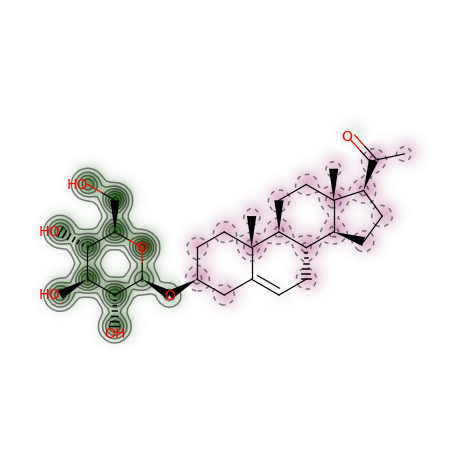

<Figure size 720x720 with 0 Axes>

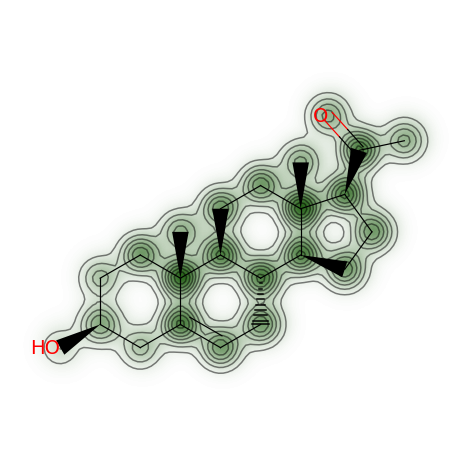

<Figure size 720x720 with 0 Axes>

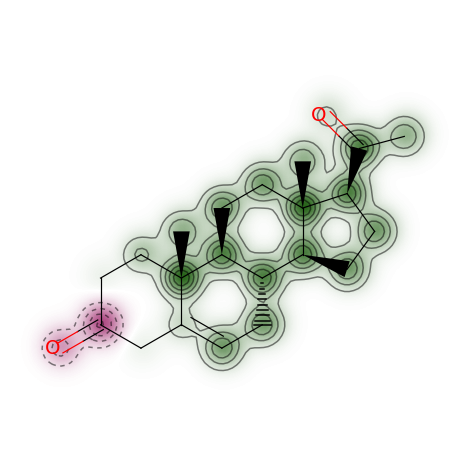

<Figure size 720x720 with 0 Axes>

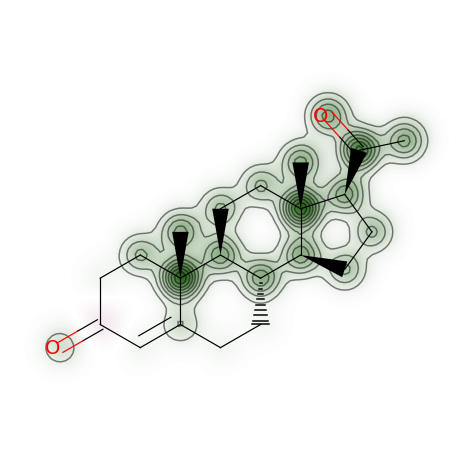

In [155]:
for x in range(len(best_path)-1):
    print(best_path[x]-best_path[x+1])
    plt.figure(figsize=(10,10))
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(get_mol_file(int(best_path[x])),get_mol_file(int(best_path[x+1])), lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.TanimotoSimilarity)
    plt.tight_layout()
    plt.savefig("{}.png".format(x),bbox_inches='tight')

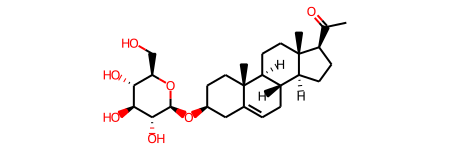

In [154]:
get_mol_file(int(best_path[x+1]))